In [1]:
import rospy

from geometry_msgs.msg import Point
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid, Path
from utils import world_points_to_path

import numpy as np
from utils import MapPoint, Map
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # Return
    return recMap

# Initiate ROS node
rospy.init_node('moro_maze_navigation')

(15, 15) -> (1.8333384916186333, 1.8333384916186333) -> (15, 15)
(15, 14) -> (1.8333384916186333, 1.6666714921593666) -> (15, 14)
(14, 14) -> (1.6666714921593666, 1.6666714921593666) -> (14, 14)
(13, 14) -> (1.5000044927001, 1.6666714921593666) -> (13, 14)
(12, 14) -> (1.3333374932408333, 1.6666714921593666) -> (12, 14)
(12, 13) -> (1.3333374932408333, 1.5000044927001) -> (12, 13)
(12, 12) -> (1.3333374932408333, 1.3333374932408333) -> (12, 12)
(12, 11) -> (1.3333374932408333, 1.1666704937815666) -> (12, 11)
(12, 10) -> (1.3333374932408333, 1.0000034943223) -> (12, 10)
(12, 9) -> (1.3333374932408333, 0.8333364948630333) -> (12, 9)
(12, 8) -> (1.3333374932408333, 0.6666694954037666) -> (12, 8)
(12, 7) -> (1.3333374932408333, 0.5000024959445) -> (12, 7)
(12, 6) -> (1.3333374932408333, 0.3333354964852333) -> (12, 6)
(12, 5) -> (1.3333374932408333, 0.16666849702596664) -> (12, 5)
(12, 4) -> (1.3333374932408333, 1.4975666999816895e-06) -> (12, 4)
(12, 3) -> (1.3333374932408333, -0.166665501

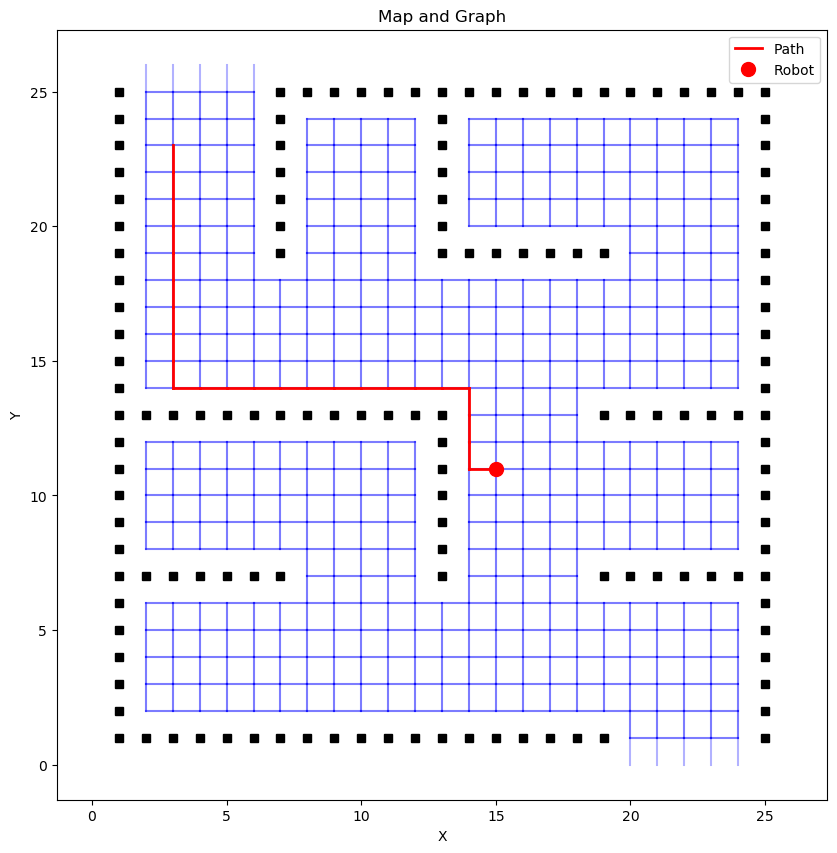

In [10]:

recMap = getMap()
grid = np.split(np.array(recMap.data), recMap.info.height)
#transpose the grid
grid = np.array(grid).T

resolution = recMap.info.resolution
origin = recMap.info.origin.position
origin = np.array([origin.x, origin.y])

def map_to_world_position(point: MapPoint) -> Point:
    """ Converts map coordinates to world coordinates """
    x = point.x
    y = point.y
    _x = (x + 0.5) * resolution + origin[0]
    _y = (y + 0.5) * resolution + origin[1]
    return Point(_x, _y, 0.0)

def world_to_map_position(x: float, y: float) -> MapPoint:
    """ Converts world coordinates to map coordinates """
    x = (x - origin[0]) / resolution - 0.5
    y = (y - origin[1]) / resolution - 0.5
    return MapPoint(int(x), int(y))

map: Map = Map(resolution, origin)

robot_position = (2, 2) # TODO: get robot position

robot = world_to_map_position(robot_position[0], robot_position[1])

goal_position = (0, 0) # TODO: get goal position

goal = world_to_map_position(goal_position[0], goal_position[1])

graph: Dict[MapPoint, List[Tuple[MapPoint, float]]] = {}

for i in range(len(grid)):
    for j in range(len(grid[i])):
        if grid[i][j] == 100:
            continue
        point = MapPoint(i, j)
        graph[point] = []
        if i == 0 or j == 0 or i == len(grid) - 1 or j == len(grid[i]) - 1:
            continue
        for x in range(-1, 2):
            for y in range(-1, 2):
                if (x == 0 and y == 0) or (abs(x) == 1 and abs(y) == 1):
                    continue
                if i + x < 0 or i + x >= len(grid) or j + y < 0 or j + y >= len(grid[i]):
                    continue
                if grid[i + x][j + y] == 100:
                    continue
                graph[point].append((MapPoint(i + x, j + y), np.sqrt(x ** 2 + y ** 2)))

# Plot the map
plt.figure(figsize=(10, 10))
for i in range(len(grid)):
    for j in range(len(grid[i])):
        if grid[i][j] == 100:
            plt.plot(j, len(grid) - i - 1, 'ks')  # Black square for obstacles
        else:
            plt.plot(j, len(grid) - i - 1, 'ws')  # White square for free space

# Plot the graph
for point, neighbors in graph.items():
    for neighbor, _ in neighbors:
        plt.plot(
            [point.y, neighbor.y],
            [len(grid) - point.x - 1, len(grid) - neighbor.x - 1],
            'b-', alpha=0.3
        )  # Blue lines for graph edges

# Get path to goal using DFS
def dfs(graph: Dict[MapPoint, List[Tuple[MapPoint, float]]], start: MapPoint, goal: MapPoint) -> List[MapPoint]:
    stack = [start]
    visited = set()
    parent = {}
    while len(stack) > 0:
        node = stack.pop()
        if node == goal:
            break
        if node in visited:
            continue
        visited.add(node)
        for neighbor, _ in graph[node]:
            if neighbor not in visited:
                stack.append(neighbor)
                parent[neighbor] = node
    path = []
    while goal != start:
        path.append(goal)
        goal = parent[goal]
    path.append(start)
    path.reverse()
    return path

# Get path to goal using BFS
def bfs(graph: Dict[MapPoint, List[Tuple[MapPoint, float]]], start: MapPoint, goal: MapPoint) -> List[MapPoint]:
    queue = [start]
    visited = set()
    parent = {}
    while len(queue) > 0:
        node = queue.pop(0)
        if node == goal:
            break
        if node in visited:
            continue
        visited.add(node)
        for neighbor, _ in graph[node]:
            if neighbor not in visited:
                queue.append(neighbor)
                parent[neighbor] = node
    path = []
    while goal != start:
        path.append(goal)
        goal = parent[goal]
    path.append(start)
    path.reverse()
    return path

path = bfs(graph, robot, goal)

# Plot the path
for i in range(len(path) - 1):
    plt.plot(
        [path[i].y, path[i + 1].y],
        [len(grid) - path[i].x - 1, len(grid) - path[i + 1].x - 1],
        'r-', linewidth=2, label="Path" if i == 0 else ""
    )

for point in path:
    world_x = map.map_to_world_position(point).x
    world_y = map.map_to_world_position(point).y
    print(f"({point.x}, {point.y}) -> ({world_x}, {world_y}) -> ({map.world_to_map_position(world_x, world_y).x}, {map.world_to_map_position(world_x, world_y).y})")


# Highlight the robot position
plt.plot(robot.y, len(grid) - robot.x - 1, 'ro', markersize=10, label="Robot")  # Red circle for robot

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title("Map and Graph")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

global_path: List[MapPoint] = bfs(graph, robot, goal)

# Convert path to world coordinates
global_path_world = [map.map_to_world_position(point) for point in global_path]

path_msg: Path = world_points_to_path(global_path_world, rospy.Time.now())

# Publish path
pub = rospy.Publisher('/move_base/global_path', Path, queue_size=10)
rospy.sleep(1.0)
pub.publish(path_msg)